### Setup

Import Caffe and the usual modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/siamese
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

### Load the trained net

Load the model definition and weights and set to CPU mode TEST phase computation with input scaling.

In [4]:
MODEL_FILE = 'mnist_siamese_fullconv.prototxt'
# decrease if you want to preview during training
PRETRAINED_FILE = 'mnist_siamese_fullconv_iter_100000.caffemodel' 
caffe.set_mode_cpu()
net = caffe.Net(MODEL_FILE, PRETRAINED_FILE, caffe.TEST)

### Load some MNIST test data

In [5]:
TEST_DATA_FILE = '../../data/mnist/t10k-images-idx3-ubyte'
TEST_LABEL_FILE = '../../data/mnist/t10k-labels-idx1-ubyte'
n = 10000

with open(TEST_DATA_FILE, 'rb') as f:
    f.read(16) # skip the header
    raw_data = np.fromstring(f.read(n * 28*28), dtype=np.uint8)

with open(TEST_LABEL_FILE, 'rb') as f:
    f.read(8) # skip the header
    labels = np.fromstring(f.read(n), dtype=np.uint8)

### Generate the Siamese features

In [6]:
# reshape and preprocess
caffe_in = raw_data.reshape(n, 1, 28, 28) * 0.00390625 # manually scale data instead of using `caffe.io.Transformer`
out = net.forward_all(data=caffe_in)

### Visualize the learned Siamese embedding

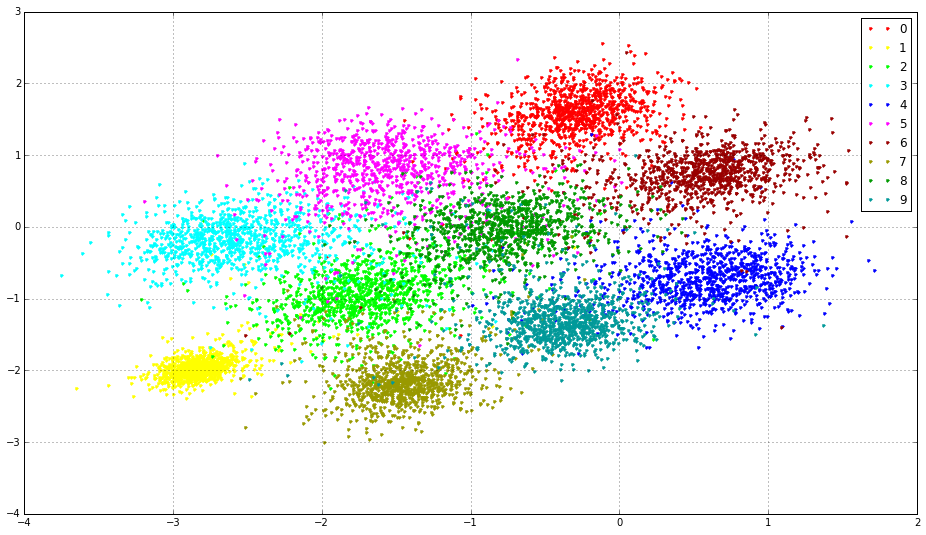

In [7]:
feat = out['feat']
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.show()

In [9]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [8]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (20L, 1L, 5L, 5L)),
 ('conv_pool1', (20L, 20L, 2L, 2L)),
 ('conv2', (50L, 20L, 5L, 5L)),
 ('conv_pool2', (50L, 50L, 2L, 2L)),
 ('ip1', (500L, 800L)),
 ('ip2', (10L, 500L)),
 ('feat', (2L, 10L))]

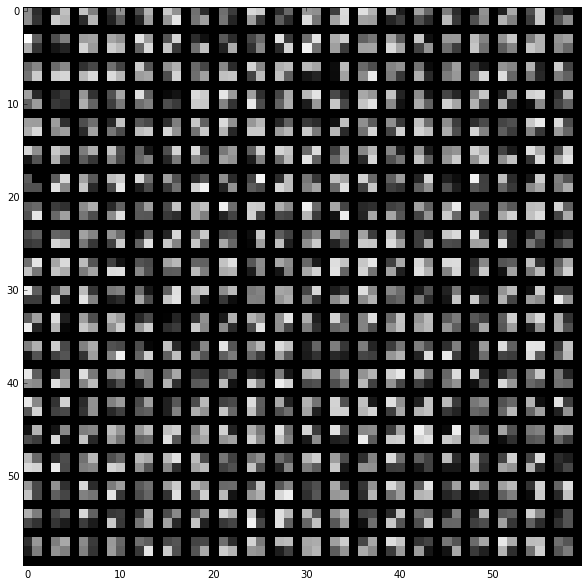

In [12]:
filters = net.params['conv_pool1'][0].data
vis_square(filters.reshape(400, 2, 2))